*Contents*
===
- [Intro](#Intro)
    - [Your teacher](#Your-teacher)
    - [Goals](#Goals)
- [The OPSD dataset](#The-OPSD-dataset)    
- [Time indexing](#Time-indexing)
    - [*to_datetime* and *Timestamp*](#to_datetime-and-Timestamp)
    - [*DatetimeIndex* and its properties](#DatetimeIndex-and-its-properties)
    - [Loading+indexing](#Loading+indexing)
    - [String and partial-string indexing](#String-and-partial-string-indexing)
    - [Exercise 1.1](#Exercise-1.1)   
- [Time series](#Time-series)
    - [Analysis vs forecast](#Analysis-vs-forecast)
    - [Univariate vs multivariate](#Univariate-vs-multivariate)
    - [Even vs uneven; dealing with frequency](#Even-vs-uneven;-dealing-with-frequency)   
- [Graphical analysis](#Graphical-analysis)
    - [Matplotlib and Seaborn](#Matplotlib-and-Seaborn)
    - [Plot examples](#Plot-examples)
    - [Multiple plots](#Multiple-plots) 
- [Seasonality](#Seasonality)
    - [Exercise 1.2](#Exercise-1.2)
    - [*groupby*](#groupby)
    - [Boxplots](#Boxplots)
    - [Exercise 1.3](#Exercise-1.3)
- [Going deeper](#Going-deeper)

Intro
===

Your teacher
---
My name is <a href="https://www.linkedin.com/in/francescobagattini/">Francesco Bagattini</a> and I am a freelance data scientist and teacher specializing in *technology transfer*: I help startups, small and medium enterprises design and develop data-driven solution powered by AI.

Goals
---
In these two classes we are going to deal with a peculiar type of data: **time series**. Let's start with a basic definition we will get back on later.

<h3><center><i>A time series is a sequence of data measured over time.</i></center></h3>

<br>

Basically, every quantity that varies in time is a time series. Some examples:

- daily minimum temperature
- total sales of a product
- air pollution level
- energy production and consumption
- web traffic
- ...infections of you favourite pandemic.

<h3><center><i>~</i></center></h3>

Let's have a look at the structure of a real-life time series. We will use both known and new Pandas tools, as well as Matplotlib and Seaborn.

Once we are able to **analyse a time series**, we will use the information we have inferred to **predict its future**.

In the meantime, here and there, we will think about the relationship with supervised learning.

The OPSD dataset
---

<img src='../img/OPSD.png' width=250/>

<br>

The **OPSD_Germany_consumption** dataset reports Germany's electric energy consumption (in GWh) from 2006 to 2017. These data are part of the [OPSD project](https://open-power-system-data.org/).

Let's start by loading the dataset as a *DataFrame*. The only mandatory parameter of the *read_csv* function is the path of the .csv file we are loading. The *head* and *tail* functions respectively show the first and last records (5 by default) of the dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('../data/OPSD_Germany_consumption.csv')
df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [2]:
df.tail()

,Date,Consumption
4378,2017-12-27,1263.94091
4379,2017-12-28,1299.86398
4380,2017-12-29,1295.08753
4381,2017-12-30,1215.44897
4382,2017-12-31,1107.11488


In [3]:
df.shape

(4383, 2)

Pandas inherits the *shape* function from NumPy. The dataframe contains 4383 records: each row reports, in addition to the consumption, the date at which the record is observed.

Pandas, at loading time, provides the dataframe with an indexing structure. Via the synthax

        df.loc[position]
        
it is possible to access the element whose index is *position*.

In [4]:
df.loc[3]

Date           2006-01-04
Consumption      1457.217
Name: 3, dtype: object

Whe are used to associate the columns of a dataset to the *features*. What about 'Date'? Is that a special feature? Which role could it have within supervised learning?

Let's have a look at its content.

In [5]:
df['Date'].dtype

dtype('O')

In Pandas, type 'O' stands for *Object*: more broadly, a string.

In [6]:
df['Date'].loc[0]

'2006-01-01'

Pandas loaded the records of the Date column as plain strings.

Time indexing
===
We aim at providing these records with a temporal structure. 

*to_datetime* and *Timestamp*
---
Pandas' *to_datatime* function tranforms a string into an object equipped with a temporal logic.

In [7]:
pd.to_datetime('10-02-09')

Timestamp('2009-10-02 00:00:00')

The function has attemped to autonomously infer the date format: October 2, 2009.
Through optional arguments we can drive this transformation.

In [8]:
pd.to_datetime('10-02-09', yearfirst=True)

Timestamp('2010-02-09 00:00:00')

In [9]:
pd.to_datetime('10-02-09', dayfirst=True)

Timestamp('2009-02-10 00:00:00')

The function handles several formats.

In [10]:
pd.to_datetime('Jan 3 2019')

Timestamp('2019-01-03 00:00:00')

As with individual strings, we can convert lists of strings; for instance, we can transform the whole Date column.

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


At first sight, nothing has changed. Let's check carefully: what type is the transformed column?

In [12]:
df.dtypes

Date           datetime64[ns]
Consumption           float64
dtype: object

Python stores temporal objects as 64-bits integers, so that to handle nanoseconds (ns) precision.

**Recap**: we have transformed a column of the dataframe into a special one, equipped with temporal logic.

*DatetimeIndex* and its properties
---
We are interested in analysing consumption *over time*. Date column can then be used as an index.

In [13]:
df.set_index('Date').head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


In [14]:
df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


Nothing has happened to the dataframe. Why? Where did we go wrong?

Often, Pandas functions return a *new* dataframe, without modifying the original one. In such cases, we have to either overwrite it or create a new one.

In [15]:
df = df.set_index('Date')

df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


Now df is correctly indexed by Date. Let's have a look at the new index.

In [16]:
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

*DatetimeIndex* has specific properties.

In [17]:
df.index.year

Int64Index([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=4383)

In [18]:
df.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='Date', length=4383)

**Recap**: we have used the time information provided by our data (the date on which each record is observed) to index a dataframe.

Loading+indexing
---

Let's achieve the same goal in a compact way. Among the arguments of read_csv, are:

- *parse_dates*
- *index_col*

which automate what we have seen so far.

In [19]:
df = pd.read_csv('../data/OPSD_Germany_consumption.csv',
                 parse_dates=True,
                 index_col='Date')
df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


**Remark**: recall that it is possible to access the documentation of a function *func* by placing the cursor to the right of a function name and pressing

    Shift Tab (Tab Tab)
    
Alternatively, we can run a cell like
    
    func?

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
dtypes: float64(1)
memory usage: 68.5 KB


**Recap**: with just one line of code we have loaded the OPSD_Germany_consumption dataset and set Date column as its time index.

String and partial-string indexing
---

Now that records have a time reference attached to, we can easily access them through *string indexing*.

Let's suppose we want to know the electric consumption of Christmas 2015.

In [21]:
df.loc['2015-12-25']

Consumption    1047.277
Name: 2015-12-25 00:00:00, dtype: float64

Automatic date format detection still works.

In [22]:
df.loc['Dec 25 2015']

Consumption    1047.277
Name: 2015-12-25 00:00:00, dtype: float64

We want to compare this record with the average consumption of December 2015.

As with *slicing* in Python and NumPy, string indexing can be used with ':' to access time intervals.

In [23]:
df.loc['2015-12-1':'2015-12-31']

,Consumption
Date,
2015-12-01,1588.021
2015-12-02,1585.308
2015-12-03,1577.457
2015-12-04,1570.318
2015-12-05,1337.095
2015-12-06,1232.073
2015-12-07,1536.251
2015-12-08,1572.740
2015-12-09,1586.393


**Remark**: in Pandas, both extrema of the interval are included in the result.

Another temporal indexing technique is *partial-string indexing*. By specifying the month and year, we extract only the records of December 2015.

In [24]:
df.loc['2015-12']

,Consumption
Date,
2015-12-01,1588.021
2015-12-02,1585.308
2015-12-03,1577.457
2015-12-04,1570.318
2015-12-05,1337.095
2015-12-06,1232.073
2015-12-07,1536.251
2015-12-08,1572.740
2015-12-09,1586.393


And here is the average consumption of December 2015.

In [25]:
df.loc['2015-12'].mean()

Consumption    1375.545516
dtype: float64

**Recap**: we have learnt how to access the elements of a time indexed dataframe.

Exercise 1.1
---

Along with electric energy consumption, the **OPSD_Germany_all** dataset reports the daily production of solar and wind energy.

**1.** Load the dataset as a dataframe, using *Date* as time index. Solar energy production is not available until December 31, 2011; from the dataframe, select only the records following this date.

**2.** Create a column *Renewable* as the sum of solar and wind energy.

**3.** Compute the ratio between **a)** the total renewable production of September 2014 and **b)** the total electric consumption of the same month.

**4.** Using the indexing properties of Date (**hint**: *index.day_name()*), create the column 'Weekday' containing, for each record, the day of the week at which it's been observed (Monday, Tuesday,...).

**5.** Create the dataframe *df_sunday_wind* containing (only) Sunday wind production.

**6.** Compute the average Sunday wind production between January and March 2017 (included).

---

Time series
===

Analysis vs forecast
---

Let's start again from the definition of time series. 

<h3><center><i>A time series is a sequence of data measured over time.</i></center></h3>

<br>

How is time involved in classic supervised learning? Once trained, a model is tested on *future* data. Generally, however, at training time all records are treated the same way; that is, they are *not temporally sorted*.

Time series provide data with a temporal relationship.

We call **analysis** the process of understanding and describing a time series of data recorded in the past; such analysis is not necessarily focused on predicting the future. 
When we explicitly use a time series to predict its future, we are **forecasting**.

Let's continue with quantitative and graphical analysis. In the next classes, we will build on these tools to make predictions.

Univariate vs multivariate
---

**Univariate** time series consist of a single variable observed over time, such as the numbers of sales of a given product or the minimum daily temperature. The dataset we have loaded at the beginning of this class is another example of univariate time series.

<img src='../img/uni.png' width=500/>

In a **multivariate** time series, multiple quantities vary over time. For example, think of a physical system where the speed along the three axes $x$, $y$ and $z$ is recorded at every time step. The **OPSD_Germany_all** dataset is a multivariate time series.

<img src='../img/multi.png' width=500/>

Even vs uneven; dealing with frequency
---

A time series can have either a fixed (daily, weekly, ...) or variable frequency. They are respectively referred to as *even* and *uneven* time series.

The frequency of the time series we have played with so far is even, daily.

We will see how Pandas handles the frequency of a time series. Let's start with *date_range*, which allows to create a temporal index with a given frequency.

In [26]:
pd.date_range('2020-03-09', '2020-05-04', freq='D')

DatetimeIndex(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
               '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
               '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03',
      

In [27]:
pd.date_range('2020-03-09', '2020-05-04', freq='W')

DatetimeIndex(['2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03'],
              dtype='datetime64[ns]', freq='W-SUN')

In [28]:
pd.date_range('2020-03-09', '2020-05-04', freq='W-MON')

DatetimeIndex(['2020-03-09', '2020-03-16', '2020-03-23', '2020-03-30',
               '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27',
               '2020-05-04'],
              dtype='datetime64[ns]', freq='W-MON')

In [29]:
pd.date_range('2020-03-09', '2020-05-04', freq='1H')

DatetimeIndex(['2020-03-09 00:00:00', '2020-03-09 01:00:00',
               '2020-03-09 02:00:00', '2020-03-09 03:00:00',
               '2020-03-09 04:00:00', '2020-03-09 05:00:00',
               '2020-03-09 06:00:00', '2020-03-09 07:00:00',
               '2020-03-09 08:00:00', '2020-03-09 09:00:00',
               ...
               '2020-05-03 15:00:00', '2020-05-03 16:00:00',
               '2020-05-03 17:00:00', '2020-05-03 18:00:00',
               '2020-05-03 19:00:00', '2020-05-03 20:00:00',
               '2020-05-03 21:00:00', '2020-05-03 22:00:00',
               '2020-05-03 23:00:00', '2020-05-04 00:00:00'],
              dtype='datetime64[ns]', length=1345, freq='H')

In [30]:
pd.date_range(start='2020-03-09', freq='D', periods=60)

DatetimeIndex(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
               '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
               '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03',
      

Let's go back to energy consumption.

In [31]:
df = pd.read_csv('../data/OPSD_Germany_consumption.csv',
                 parse_dates=True,
                 index_col='Date')

df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


In [32]:
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

When Pandas loads a .csv, the frequency information is ignored, and has to be explicitly set through the *asfreq* function.

In [33]:
df.asfreq('D').head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


In [34]:
df.asfreq('D').index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq='D')

Let's see what happens if we assign a frequency to a time index with 'holes' in it.

In [35]:
some_days = pd.to_datetime(['2012-01-01', '2012-01-04', '2012-01-07'])

some_days

DatetimeIndex(['2012-01-01', '2012-01-04', '2012-01-07'], dtype='datetime64[ns]', freq=None)

In [36]:
df.loc[some_days]

,Consumption
2012-01-01,948.128
2012-01-04,1347.136
2012-01-07,1175.688


In [37]:
df.loc[some_days].asfreq('D')

,Consumption
2012-01-01,948.128
2012-01-02,NaN
2012-01-03,NaN
2012-01-04,1347.136
2012-01-05,NaN
2012-01-06,NaN
2012-01-07,1175.688


The arguments of asfreq allow to choose how to fill the holes.

In [38]:
df.loc[some_days].asfreq('D', method='ffill')

,Consumption
2012-01-01,948.128
2012-01-02,948.128
2012-01-03,948.128
2012-01-04,1347.136
2012-01-05,1347.136
2012-01-06,1347.136
2012-01-07,1175.688


In [39]:
df.loc[some_days].asfreq('D', fill_value=0)

,Consumption
2012-01-01,948.128
2012-01-02,0.000
2012-01-03,0.000
2012-01-04,1347.136
2012-01-05,0.000
2012-01-06,0.000
2012-01-07,1175.688


As usual, we can refer to the documentation without leaving Jupyter.

**Recap**: we have seen the difference between analysis and forecast, and defined time series with specific traits. Moreover, we have learnt how to handle the frequency of time indexed Pandas dataframe.

---

Graphical analysis
===

Let's start our time series analysis using Python data visualization tools.

Matplotlib and Seaborn
---

<a href="https://matplotlib.org/">Matplotlib</a> is a highly customizable library, though a bit tricky at first. <a href="https://seaborn.pydata.org/.">Seaborn</a> standardises some graphical aspects and easily integrates with Pandas.

Importing Matplotlib is enough to visualise graphical outputs on Jupyter.

In [40]:
import matplotlib.pyplot as plt

df = pd.read_csv('../data/OPSD_Germany_all.csv',
                 parse_dates=True,
                 index_col='Date')

df.head()

,Consumption,Wind,Solar
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN
2006-01-04,1457.217,NaN,NaN
2006-01-05,1477.131,NaN,NaN


The *plot* function pictures the content of a dataframe or a *Series* (an individual column of a dataframe).

<AxesSubplot:xlabel='Date'>

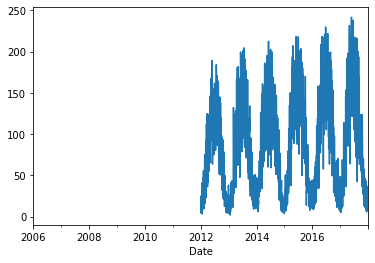

In [41]:
df_solar = df['Solar']

df_solar.plot()

In [42]:
import seaborn as sns

Once that Seaborn has been imported, we can use the *set* function to force its default graphical settings.

In [43]:
sns.set()

<AxesSubplot:xlabel='Date'>

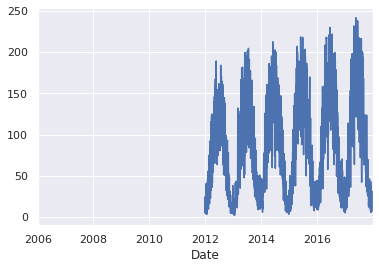

In [44]:
df_solar.plot()

Plot examples
---

Seaborn's *plot* function has many optional arguments.

<AxesSubplot:title={'center':'Solar energy production (GWh)'}, xlabel='Date'>

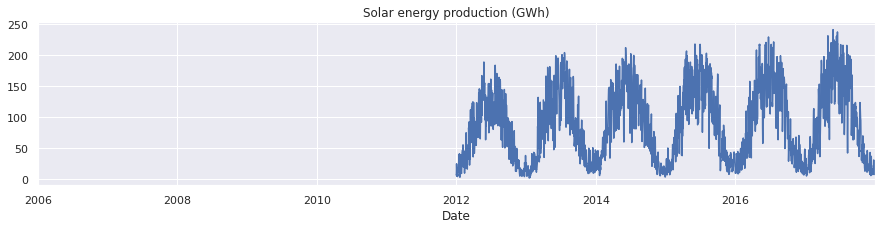

In [45]:
df_solar.plot(figsize=(15, 3), title='Solar energy production (GWh)')

Some of these arguments are linked to Matplotlib properties and not directly available within the function documentation. A complete list of such properties can be found [here](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.lines.Line2D.html).

<AxesSubplot:title={'center':'Solar energy production (GWh)'}, xlabel='Date'>

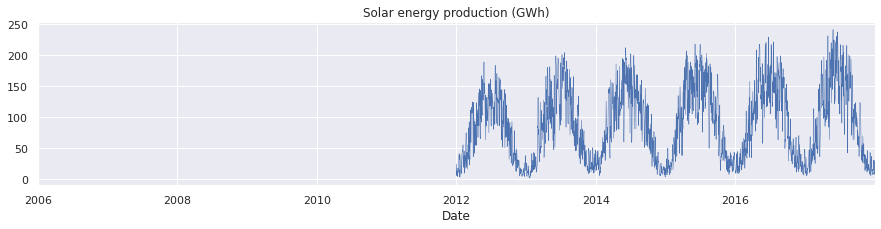

In [46]:
df_solar.plot(figsize=(15, 3), title='Solar energy production (GWh)', linewidth=.5)

<AxesSubplot:title={'center':'Solar energy production (GWh)'}, xlabel='Date'>

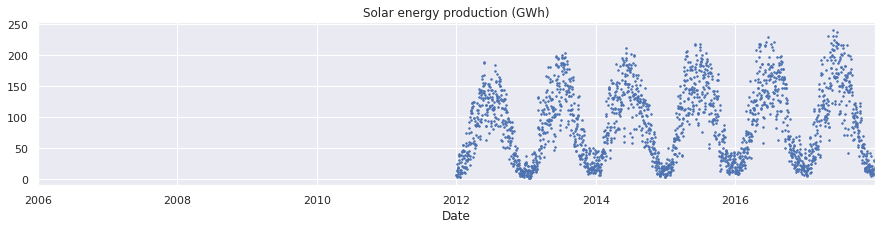

In [47]:
df_solar.plot(figsize=(15, 3),
              title='Solar energy production (GWh)',
              marker='.',
              markersize=3,
              linestyle='')

<AxesSubplot:title={'center':'Solar energy production (GWh)'}, xlabel='Date'>

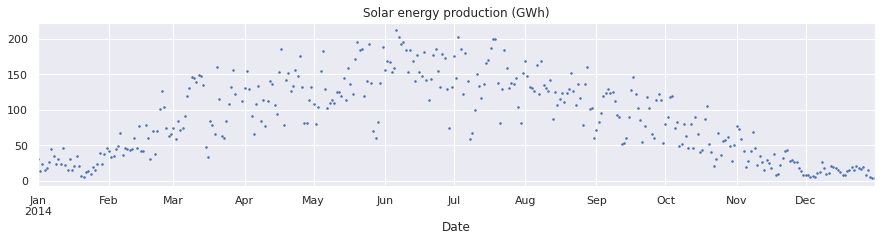

In [48]:
df_solar['2014'].plot(figsize=(15, 3),
                      title='Solar energy production (GWh)',
                      marker='.',
                      markersize=3,
                      linestyle='')

Note how plots are indexed based on the granularity of data.

<AxesSubplot:title={'center':'Solar energy production (GWh)'}, xlabel='Date'>

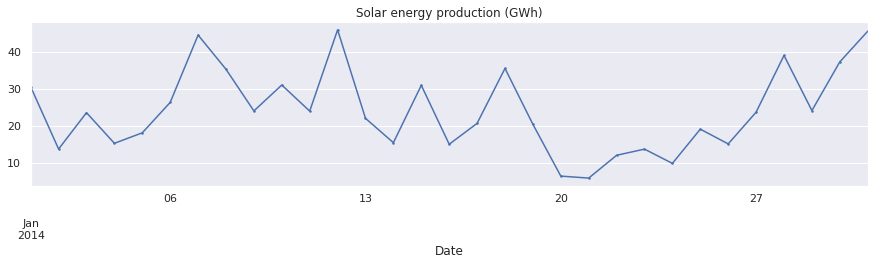

In [49]:
df_solar['2014-01'].plot(figsize=(15, 3),
                         title='Solar energy production (GWh)',
                         marker='.',
                         markersize=3,
                         linestyle='-')

Multiple plots
---

Let's try to *simultaneously* visualise solar and wind energy production.

<AxesSubplot:title={'center':'Renawable energy production (GWh)'}, xlabel='Date'>

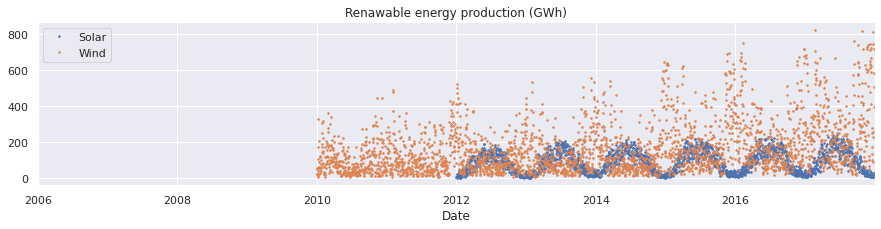

In [50]:
df_renewable = df[['Solar', 'Wind']]

df_renewable.plot(figsize=(15, 3),
                  title='Renawable energy production (GWh)',
                  marker='.',
                  markersize=3,
                  linestyle='')

The *subplots* argument creates a plot for each column of the dataframe.

array([<AxesSubplot:title={'center':'Solar energy production'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'Wind energy production'}, xlabel='Date'>],
      dtype=object)

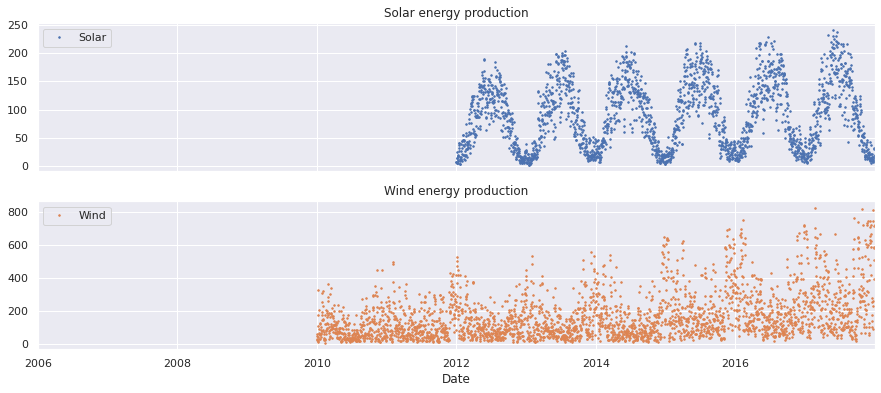

In [51]:
subplots = df_renewable.plot(figsize=(15, 6),
                             marker='.',
                             markersize=3,
                             linestyle='',
                             title=['Solar energy production', 'Wind energy production'],
                             subplots=True)

subplots

Pandas plot function is nothing but a shortcut to that of Matplotlib. For some specific graphical results (like the following) it is preferable to use the latter.

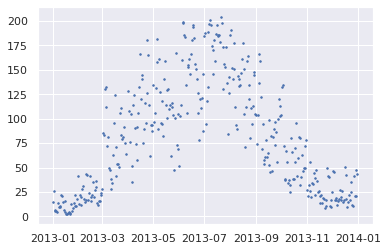

In [52]:
plt.plot(df['Solar']['2013'],
         linestyle='',
         marker='.',
         markersize=3)

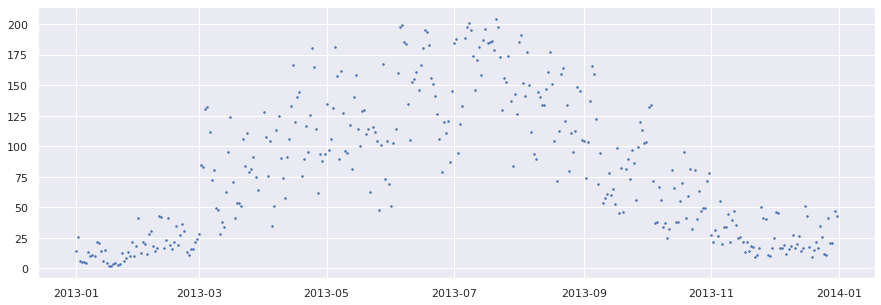

In [53]:
plt.figure(figsize=(15, 5))

plt.plot(df['Solar']['2013'],
         linestyle='',
         marker='.',
         markersize=3)

We now want the wind production to be added to the plot, though with a different graphical style.

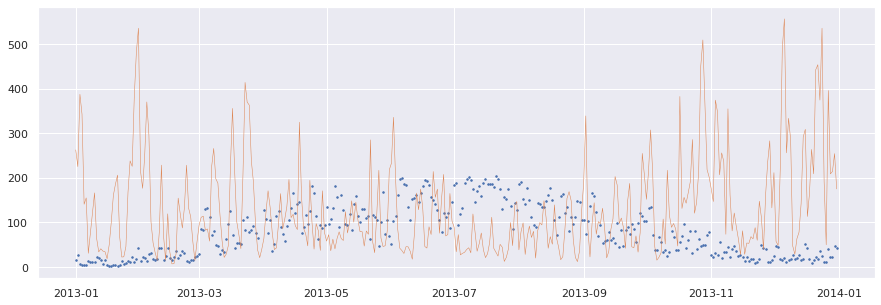

In [54]:
plt.figure(figsize=(15, 5))

plt.plot(df['Solar']['2013'],
         linestyle='',
         marker='.',
         markersize=3)

plt.plot(df['Wind']['2013'],
         linestyle='-',
         linewidth=0.5)

Let's further customize the plot by adding a legend and a title.

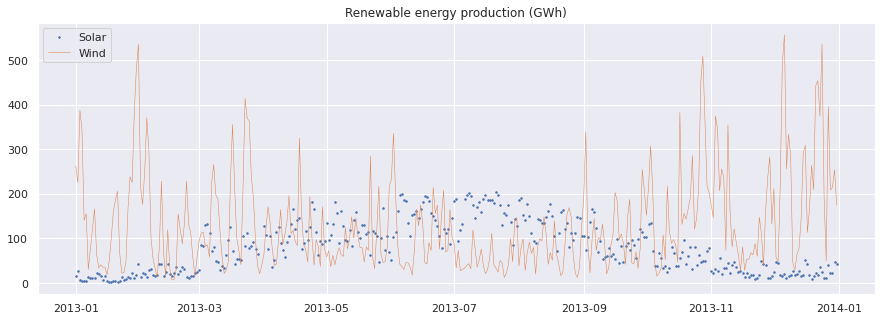

In [55]:
plt.figure(figsize=(15, 5))

plt.plot(df['Solar']['2013'],
         linestyle='',
         marker='.',
         markersize=3,
         label='Solar')

plt.plot(df['Wind']['2013'],
         linestyle='-',
         linewidth=0.5,
         label='Wind')

plt.title('Renewable energy production (GWh)')
plt.legend()

**Hint**: think of each cell as an independent graphical environment.

It takes some time to become familiar with Matplotlib. However,

- it is a really versatile tool
- the Web is full with examples.

**Recap**: we have seen how to plot the content of a Dataframe with Pandas. We used Matplotlib to create sequential plots, wherein each subplot has specific graphical properties.

Seasonality
===

The tendency of a variable to periodically reapeat its behaviour is called **seasonality**.

(Yearly) seasonality is straightforward with solar energy: every year we observe the same behaviour, due to the availability of sunlight.

Seasonality is not necessarily meterological: think of sales during Christmas holidays.

Exercise 1.2
---

Use the tools we have seen so far to plot the consumption of electric energy.

What kind of seasonality can we observe on this variable? How can it be interpreted?

---

**Recap**: we have analised the seasonality of a time series by zooming in on a given time interval.

Our next goal is to represent the seasonality of the whole series.

*groupby*
---

Pandas *groupby* allows to group records based on one ore more properties and extract statistics from each group. We need three ingredients:

- those variables based on which we build the groups
- those variables of which we want to know the behaviour within each group
- the statistics we extract from the latter, group by group.

Let's use groupby to analise the yearly seasonality of electric energy production.

In [56]:
df['Month'] = df.index.month_name()

df.head()

,Consumption,Wind,Solar,Month
Date,,,,
2006-01-01,1069.184,NaN,NaN,January
2006-01-02,1380.521,NaN,NaN,January
2006-01-03,1442.533,NaN,NaN,January
2006-01-04,1457.217,NaN,NaN,January
2006-01-05,1477.131,NaN,NaN,January


In [57]:
df.groupby('Month').mean()

,Consumption,Wind,Solar
Month,,,
April,1298.457644,148.644725,119.734933
August,1249.991327,109.350778,138.778575
December,1374.364568,277.566526,20.068538
February,1452.463841,206.942903,43.846735
January,1433.781435,207.716480,19.569602
July,1266.701788,112.376440,150.746720
June,1263.169508,114.812058,152.569494
March,1380.694497,174.218785,88.038121
May,1261.905065,129.161601,139.967312


In [58]:
df.groupby('Month', sort=False).mean()

,Consumption,Wind,Solar
Month,,,
January,1433.781435,207.716480,19.569602
February,1452.463841,206.942903,43.846735
March,1380.694497,174.218785,88.038121
April,1298.457644,148.644725,119.734933
May,1261.905065,129.161601,139.967312
June,1263.169508,114.812058,152.569494
July,1266.701788,112.376440,150.746720
August,1249.991327,109.350778,138.778575
September,1314.348716,127.731125,103.247256


In [59]:
df.groupby('Month', sort=False)['Solar'].mean()

Month
January       19.569602
February      43.846735
March         88.038121
April        119.734933
May          139.967312
June         152.569494
July         150.746720
August       138.778575
September    103.247256
October       61.328371
November      30.869122
December      20.068538
Name: Solar, dtype: float64

In this example, who are the three ingredients we have mentioned earlier?

<AxesSubplot:title={'center':'Average monthly solar energy production (GWh)'}, xlabel='Month'>

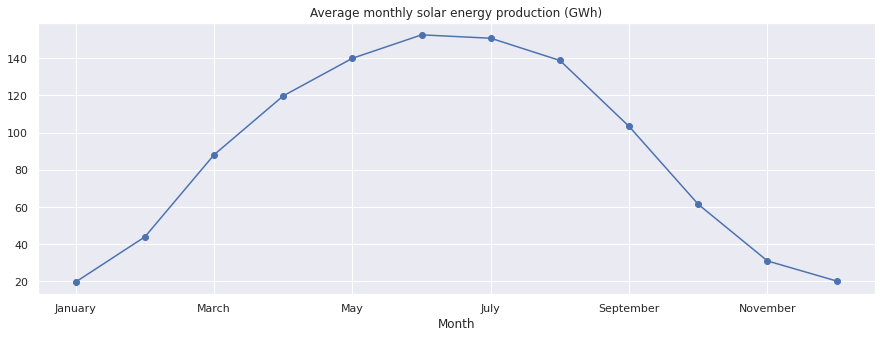

In [60]:
df.groupby('Month', sort=False)['Solar'].mean().plot(figsize=(15, 5),
                                                     marker='o',
                                                     title='Average monthly solar energy production (GWh)')

Boxplots
---
A *boxplot* has an informative content similar to that of groupby, though a bit richer.

<AxesSubplot:xlabel='Month', ylabel='Consumption'>

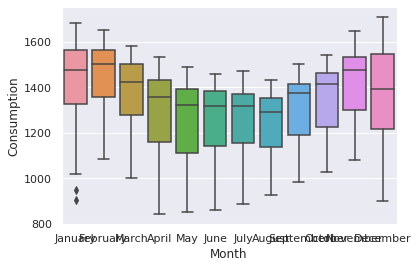

In [61]:
sns.boxplot(x='Month',
            y='Consumption',
            data=df)

We don't like the graphical outcome: we surely have to act on the *figsize* property. Unfortunately, the latter is not available among the arguments of Seaborn *boxplot* function. 

Again, we need Matplotlib.

<AxesSubplot:xlabel='Month', ylabel='Consumption'>

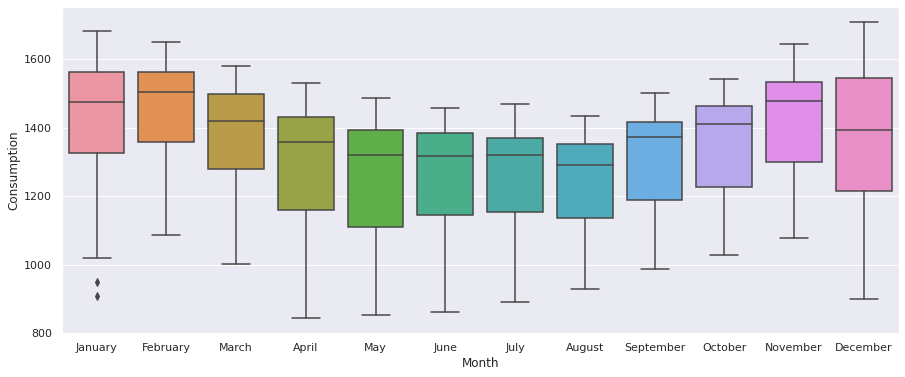

In [62]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month',
            y='Consumption',
            data=df)

There we go. Finally, let's learn [how to read a boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51).

Exercise 1.3
---
Analise the weekly seasonality of electric energy consumption using the groupby (Pandas) and boxplot (Seaborn) functions.

Going deeper
===

To get ready for the next lesson, first review this one and try to solve the exercises (without peeking at the solutions).

Then, here are some random hints to delve deeper into time series:

- there are plenty of time dependent data out there: **look for your time series** and prepare it for analysis

- think (meaning brain, pen and paper) about how time series and classic supervised learning are related to each other (hyperparameter validation? time series as rows instead of columns? turning a time series into a supervised learning task?)

- boxplot is a nice tool, got it. Is it always that? First, think; then look [here](https://www.data-to-viz.com/caveat/boxplot.html) and play with [this](https://seaborn.pydata.org/generated/seaborn.boxplot.html) and [this](https://seaborn.pydata.org/generated/seaborn.violinplot.html)

- explore Matplotlib properties as well as Seaborn functions (and their many arguments). 

---

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('div.prompt').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by OVHCloud.
</footer>